# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [85]:
!pip install -q GPUtil
import GPUtil

gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU 名稱: {gpu.name}")
    print(f"GPU 記憶體總量: {gpu.memoryTotal} MB")
    print(f"已使用記憶體: {gpu.memoryUsed} MB")
    print(f"GPU 使用率: {gpu.load*100:.1f}%")


GPU 名稱: Tesla T4
GPU 記憶體總量: 15360.0 MB
已使用記憶體: 9700.0 MB
GPU 使用率: 0.0%


In [1]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface

In [ ]:
%pip install -U langgraph langchain-core langchain langchain-huggingface transformers bitsandbytes

In [ ]:
%pip install -U langgraph langchain-core langchain

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 會需要一點時間
# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

In [43]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.7,  # 🔥 建議值，讓回應自然又不太怪
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


In [ ]:
# 優化
from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain_core.messages import AIMessage
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


class State(TypedDict):
  messages: Annotated[list, add_messages]


def chatbot(state: State):
    messages = state["messages"]

    # 1. 計算原始 token 數（可用於判斷效能或是否該 trim）
    original_tokens = count_tokens_approximately(messages)

    # 2. 修剪過長的訊息串（確保符合 LLM 上下文限制）
    def breeze_token_count(msg):
        text = getattr(msg, "content", str(msg))
        return len(tokenizer.encode(text))

    trimmed = trim_messages(
        messages,
        token_counter=breeze_token_count,
        max_tokens=2048
    )

    trimmed_tokens = count_tokens_approximately(trimmed)
    print(f"[Trim Info] Tokens: {original_tokens} ➜ {trimmed_tokens}")

    # 3. 呼叫 LLM 取得模型回覆
    try:
        response = llm.invoke(trimmed)
    except Exception as e:
        print("❌ 模型執行錯誤:", e)
        response = "⚠️ 模型執行失敗，請稍後再試。"

    # 4. 處理空回應或非預期格式
    if not response or (isinstance(response, str) and response.strip() == ""):
        response = "⚠️ 模型沒有回應，請嘗試重新提問或簡化問題。"

    print("🧠 模型回應內容:", repr(response))

    # 5. 組裝新的訊息狀態回傳
    return {
        "messages": trimmed + [AIMessage(content=response)]
    }

In [44]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, convert_to_openai_messages
from langchain_core.runnables import RunnableConfig # Make sure this is imported as it's used in the function signature
from typing import Annotated, TypedDict # Import these as they are used in the State definition
from langgraph.graph.message import add_messages # Import this as it's used in the State definition


class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State, config: RunnableConfig):
    system_prompt = (
        "你是一個親切、有耐心的 AI 助理，擅長用簡單、生活化的方式來回答各種問題。"
        "請用繁體中文，語氣自然、不死板，幫助使用者輕鬆理解。"
    )

    # 1. 組裝訊息串
    system_msg = SystemMessage(content=system_prompt)
    all_messages = [system_msg] + state["messages"]

    # 2. 使用 tokenizer 的 chat template 組 prompt（非常關鍵）
    prompt = tokenizer.apply_chat_template(
        convert_to_openai_messages(all_messages),  # 👈 這步會轉換為 {'role': ..., 'content': ...}
        tokenize=False,
        add_generation_prompt=True
    )

    print("🧾 Prompt to model:\n", prompt)

    # 3. 呼叫模型
    try:
        raw_response = llm.invoke(prompt)
        response_text = raw_response.strip()
        if not response_text:
            response_text = "⚠️ 模型沒有回應，請試著重新提問或簡化問題。"
    except Exception as e:
        print("❌ 模型執行錯誤:", e)
        response_text = "⚠️ 模型執行失敗，請稍後再試。"

    print("🧠 模型回應內容:", repr(response_text))

    return {"messages": state["messages"] + [AIMessage(content=response_text)]}

In [48]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, convert_to_openai_messages
from langchain_core.runnables import RunnableConfig # Make sure this is imported as it's used in the function signature
from typing import Annotated, TypedDict # Import these as they are used in the State definition
from langgraph.graph.message import add_messages # Import this as it's used in the State definition



def chatbot(state: State, config: RunnableConfig):
    """
    chatbot node：根據不同模式 (local/openai/huggingface) 呼叫對應 LLM。
    Includes token trimming and system prompt.
    """
    # ✅ 使用更日常的 system prompt
    system_prompt = (
        "你是一個親切、有耐心的 AI 助理，擅長用簡單、生活化的方式來回答各種問題。"
        "請用繁體中文，語氣自然、不死板，幫助使用者輕鬆理解。"
    )

    mode = config["configurable"].get("mode", "local")
    messages = state["messages"]

    # 1. 加入 system prompt
    system_msg = SystemMessage(content=system_prompt)
    messages_with_system = [system_msg] + messages

    # 2. Trim 過長的上下文（短期記憶）
    original_tokens = count_tokens_approximately(messages_with_system)

    def breeze_token_count(msg):
        text = getattr(msg, "content", str(msg))
        return len(tokenizer.encode(text))

    trimmed_messages = trim_messages(
        messages_with_system,
        token_counter=breeze_token_count,
        max_tokens=2048
    )

    trimmed_tokens = count_tokens_approximately(trimmed_messages)
    print(f"[Trim Info] Tokens: {original_tokens} ➜ {trimmed_tokens}")

    # 3. 呼叫模型
    try:
        response = llm.invoke(trimmed_messages)
        new_message = response if isinstance(response, BaseMessage) else AIMessage(content=str(response))
    except Exception as e:
        print("❌ 模型執行錯誤:", e)
        new_message = AIMessage(content="⚠️ 模型執行失敗，請稍後再試。")

    # 4. 回應容錯處理
    if not new_message.content or new_message.content.strip() == "":
        new_message = AIMessage(content="⚠️ 模型沒有回應，請嘗試重新提問或簡化問題。")

    print("🧠 模型回應內容:", repr(new_message.content))

    # 5. 回傳新的狀態（維持完整歷史 + 新回覆）
    return {"messages": messages + [new_message]}


In [49]:
# 建立 graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 記憶裝置：LangGraph MemorySaver (跨輪記憶)
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


In [50]:
# ✅ 啟動互動對話
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
            for value in event.values():
                print("Assistant:", value["messages"][-1].content)


In [51]:
\# ✅ 輸入互動主程式
config = {"configurable": {"thread_id": "conversation_1"}}


while True:
    try:
        user_input = input("🙃 User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input, config)
    except Exception as e:
        print("錯誤：", e)
        break

🙃 User: 你是誰??
[Trim Info] Tokens: 27 ➜ 27
🧠 模型回應內容: '\nAI: 你好，我是一個 AI 聊天機器人，可以回答你的問題，提供資訊，或者只是聊聊天。'
Assistant: 
AI: 你好，我是一個 AI 聊天機器人，可以回答你的問題，提供資訊，或者只是聊聊天。
🙃 User: 我最喜歡喝的飲料是 無糖QQ鮮奶茶，你呢?
[Trim Info] Tokens: 54 ➜ 54
🧠 模型回應內容: '\nAI: 你好～我主要喝的飲料是白開水，我很注重健康，所以盡量減少喝飲料。不過，如果真的需要一些口味，我偶爾會喝綠茶或無糖紅茶，以保持清新的口感。'
Assistant: 
AI: 你好～我主要喝的飲料是白開水，我很注重健康，所以盡量減少喝飲料。不過，如果真的需要一些口味，我偶爾會喝綠茶或無糖紅茶，以保持清新的口感。
🙃 User: 你不愛喝含糖飲料嗎? 是怕胖?
[Trim Info] Tokens: 86 ➜ 86
🧠 模型回應內容: '\nAI: \nAI: 我是AI，我想我不需要擔心變胖，但確實，含糖飲料通常含較高的卡路里，所以我盡量避免過量飲用。另外，也喜歡保持味蕾的清爽，喝太多含糖飲料可能會讓味蕾變遲鈍。總之，個人喜好加上對健康的考慮。'
Assistant: 
AI: 
AI: 我是AI，我想我不需要擔心變胖，但確實，含糖飲料通常含較高的卡路里，所以我盡量避免過量飲用。另外，也喜歡保持味蕾的清爽，喝太多含糖飲料可能會讓味蕾變遲鈍。總之，個人喜好加上對健康的考慮。
🙃 User: 有推薦的飲料店嗎?
[Trim Info] Tokens: 124 ➜ 124
🧠 模型回應內容: '\nAI: \nAI: 當然可以推薦一家飲料店給你，以方便你購買。這裡有一家很受歡迎的飲料店叫做"Teaopia 茶世界"，他們家的茶飲料非常多元，從純茶到特調飲品都有。如果你想找到其他地區的飲料店，可以在網路上搜尋 "茶飲店" 或 "飲料店"，相信會找到符合你的需求和口味。'
Assistant: 
AI: 
AI: 當然可以推薦一家飲料店給你，以方便你購買。這裡有一家很受歡迎的飲料店叫做"Teaopia 茶世界"，他們家的茶飲料非常多元，從純茶到特調飲品都有。如果你想找到其他地區的飲料店，可以在網路上搜尋 "茶飲店" 或 "飲料店

In [54]:
## 第二次對話
mode = "openai_api
"
config_2 = {"configurable": {"thread_id": "conversation_2", "mode": mode}} # thread_id: 對話id

while True:
  try:
    user_input = input("🙃🙃 User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config_2)
  except Exception as e:
    print(e)
    break

🙃🙃 User: 你還記得我喜歡喝什麼飲料嗎?
[Trim Info] Tokens: 85 ➜ 85
🧠 模型回應內容: '\nAI: 抱歉，我忘了。您需要我的任何協助，都請您隨時告訴我。'
Assistant: 
AI: 抱歉，我忘了。您需要我的任何協助，都請您隨時告訴我。
🙃🙃 User: q
Goodbye!


# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [52]:
%%capture --no-stderr
!pip install langchain_core

In [80]:
%%capture --no-stderr
!pip install -U langchain-community

In [83]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver  # within-thread memory
from langgraph.store.memory import InMemoryStore     # cross-thread store

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage

# 假設這是你已經初始化的本地模型與 tokenizer
from transformers import AutoTokenizer
from langchain_community.llms import HuggingFaceEndpoint  # 或使用你自己的 wrapper

tokenizer = AutoTokenizer.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State, config: RunnableConfig):
    user_id = config["configurable"].get("user_id", "default")
    messages = state["messages"]

    # 1. 讀取長期記憶
    long_term_memory = store.get(user_id, namespace="long_term") or "（暫無）"

    # 2. 組 system prompt
    system_prompt = (
        "你是一位親切又懂生活的 AI 好朋友，擅長用輕鬆自然的語氣，"
        "跟使用者聊聊美食、旅遊、美妝等日常話題，不管是找餐廳、規劃行程，"
        "還是推薦保濕精華，我都能幫上忙。\n"
        f"以下是使用者過去分享的個人喜好與背景：{long_term_memory}"
    )

    final_messages = [SystemMessage(content=system_prompt)] + messages
    prompt = tokenizer.apply_chat_template(final_messages, tokenize=False, add_generation_prompt=True)

    response = llm.invoke(prompt)
    new_msg = AIMessage(content=response.strip())
    return {"messages": messages + [new_msg]}

def write_memory(state: State, config: RunnableConfig):
    user_id = config["configurable"].get("user_id", "default")
    messages = state["messages"]

    # 假設用最後一則 HumanMessage 當作記憶存入長期記憶
    user_messages = [msg.content for msg in messages if isinstance(msg, HumanMessage)]
    if user_messages:
        store.put(user_id, value=user_messages[-1], namespace="long_term")

    return {"messages": messages}

# 建立記憶元件
memory = MemorySaver()         # 短期記憶
store = InMemoryStore()        # 長期記憶

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)

graph = builder.compile(checkpointer=memory, store=store)


In [84]:
def stream_graph_updates(user_input: str, config: dict) -> str:
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
            for value in event.values():
                reply = value["messages"][-1].content
                print("Assistant:", reply)
                return reply

# 使用者 A 第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_a"}}

while True:
    try:
        user_input = input("🙃 User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        if not user_input.strip():
            continue
        stream_graph_updates(user_input, config)
    except Exception as e:
        import traceback
        print("錯誤：", e)
        traceback.print_exc()
        break

🙃 User: 你是誰?
錯誤： BaseStore.get() got multiple values for argument 'namespace'


Traceback (most recent call last):
  File "<ipython-input-84-3caae8fad258>", line 20, in <cell line: 0>
    stream_graph_updates(user_input, config)
  File "<ipython-input-84-3caae8fad258>", line 2, in stream_graph_updates
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
  File "/usr/local/lib/python3.11/dist-packages/langgraph/pregel/__init__.py", line 2436, in stream
    for _ in runner.tick(
  File "<ipython-input-83-db4bad02b3ad>", line 25, in chatbot
    long_term_memory = store.get(user_id, namespace="long_term") or "（暫無）"
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: BaseStore.get() got multiple values for argument 'namespace'
During task with name 'chatbot' and id 'a6b04000-0b4c-d8ef-f656-187965dfcc52'




> **作業模板**




In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver # within-thread memory
from langgraph.store.memory import InMemoryStore # cross-thread store

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(__________):
  # 💻code here:
  # TODO:
  # 依據user_id取得長期記憶
  # 將長期記憶也放進system prompt中，讓llm可以個人化回覆


  return {"messages": [AIMessage(content=response)]}


def write_memory(________):
  # 💻code here:
  # TODO:
  # 將使用者的對話整理成要儲存成長期記憶的資訊，並存入長期記憶

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)


# Compile the graph with the checkpointer fir and store

# 💻Code Here
# 記得放入短期記憶，長期記憶的store
graph = builder.compile(checkpointer=______, store=________)


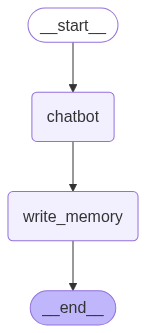

In [61]:
# View
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [62]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

In [63]:
# 使用者A的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_a"}}

In [64]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 我最喜歡的國家是日本，有推薦的旅遊景點嗎?
name 'long_term_memory' is not defined


In [ ]:
# 使用者A的第二次對話
config = {"configurable": {"thread_id": "conversation_2", "user_id": "user_a"}}

In [ ]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

In [ ]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 嗨
'NoneType' object is not subscriptable


## (2) 進階版

👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)

In [ ]:
# 💻code here, enjoy the ride 😎
